In [81]:
# in comments potential filtering steps

In [73]:
# group t cells
# sc_counts.obs['cell_type'] = sc_counts.obs['cell_type'].apply(lambda x: 'T cells' if  x.startswith("T ") else x)

In [74]:
# do sctk filtering
# import sctk
# 
# sctk.calculate_qc(sc_counts, flags={"mito": r"^MT-", "ribo": r"^RP[LS]"})
# sctk.cellwise_qc(sc_counts)
# sc_counts = sc_counts[sc_counts.obs.cell_passed_qc]

In [75]:
# filter out wells with less than 200 cells
# sc_counts.obs["library_well"] = sc_counts.obs["library_id"].astype(str) + "_" + sc_counts.obs["well"].astype(str)
# sc_counts = sc_counts[sc_counts.obs["library_well"].map(sc_counts.obs["library_well"].value_counts()) >= 200]

In [76]:
# filter out genes expressed in less than 100 cells per plate
# import numpy as np
# import pandas as pd
# 
# plates = sc_counts.obs['plate_name'].unique()
# gene_counts_per_plate = pd.DataFrame(index=sc_counts.var_names, columns=plates, dtype=int)
# 
# for plate in plates:
#     subset = sc_counts[sc_counts.obs['plate_name'] == plate]
#     expressed_genes = (subset.X > 0).sum(axis=0)
#     if isinstance(expressed_genes, np.matrix):
#         expressed_genes = np.array(expressed_genes).flatten()
#     gene_counts_per_plate[plate] = expressed_genes
# max_counts = gene_counts_per_plate.max(axis=1)
# 
# genes_to_keep = max_counts >= 100
# sc_counts = sc_counts[:, genes_to_keep]

In [77]:
# sc_counts.obs['plate_well_cell_type'] = sc_counts.obs['plate_name'].astype('str') \
#     + '_' + sc_counts.obs['well'].astype('str') \
#     + '_' + sc_counts.obs['cell_type'].astype('str')
# sc_counts.obs['plate_well_cell_type'] = sc_counts.obs['plate_well_cell_type'].astype('category')
# sc_counts = sc_counts[sc_counts.obs["plate_well_cell_type"].map(sc_counts.obs["plate_well_cell_type"].value_counts()) > 10]

In [112]:
import anndata as ad
import scanpy as sc
import pandas as pd

In [ ]:
data_dir = "/Users/arturszalata/PycharmProjects/task-dge-perturbation-prediction/resources/neurips-2023-data"
sc_counts = ad.read_h5ad(f'{data_dir}/sc_counts_cleaned.h5ad')

In [70]:
del sc_counts.obsm["X_pca"]
del sc_counts.obsm["X_umap"]

In [71]:
sc_counts.raw = sc_counts.copy()
sc.pp.normalize_total(sc_counts, target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(sc_counts)
sc.pp.highly_variable_genes(sc_counts, n_top_genes=2000)
adata_hvg = sc_counts[:, sc_counts.var.highly_variable].copy()

sc.pp.neighbors(adata_hvg)
sc.tl.umap(adata_hvg)
sc_counts.obsm['X_umap'] = adata_hvg.obsm['X_umap']

         Falling back to preprocessing with `sc.pp.pca` and default params.


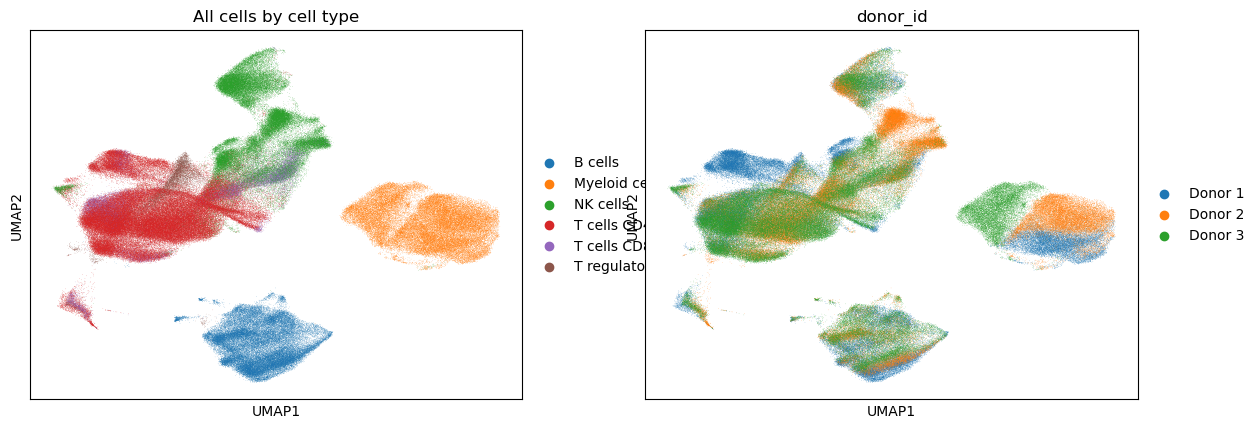

In [83]:
sc.pl.umap(sc_counts, color=['cell_type', 'donor_id'], title="All cells by cell type")

In [79]:
sc.tl.leiden(adata_hvg, key_added="leiden_res1", resolution=1.0)

In [94]:
sc_counts.obs["leiden_res1"] = adata_hvg.obs.leiden_res1

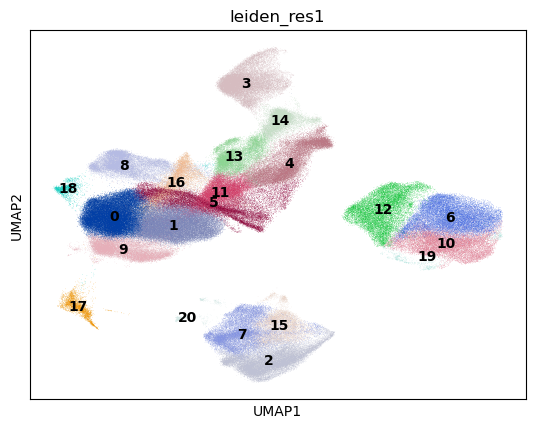

In [95]:
sc.pl.umap(
    sc_counts,
    color=["leiden_res1"],
    legend_loc="on data",
)

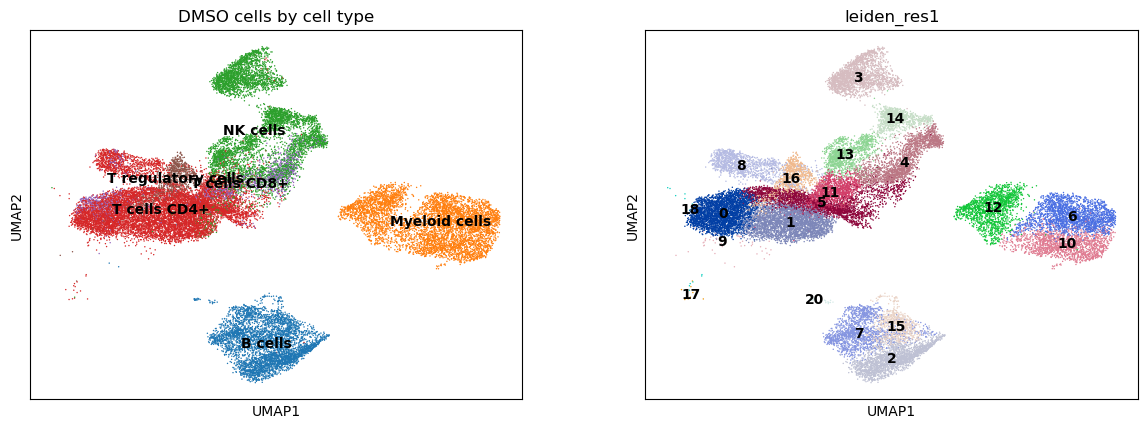

In [96]:
sc.pl.umap(sc_counts[(sc_counts.obs.sm_name == "Dimethyl Sulfoxide")], color=['cell_type', "leiden_res1"], title="DMSO cells by cell type", legend_loc="on data")

/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_10446/437383831.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dmso_counts = sc_counts.obs.groupby('leiden_res1')['is_dmso'].mean() * 100


AttributeError: Rectangle.set() got an unexpected keyword argument 'title'

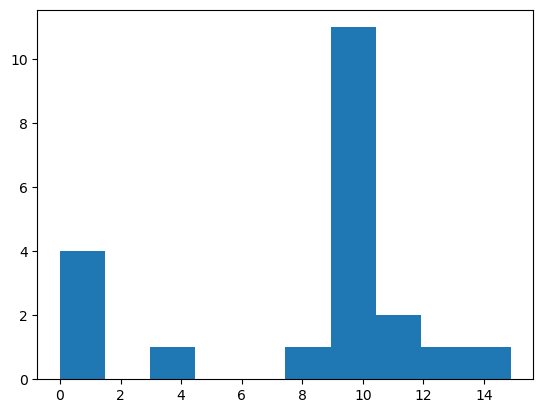

In [97]:
sc_counts.obs['is_dmso'] = sc_counts.obs['sm_name'] == "Dimethyl Sulfoxide"
dmso_counts = sc_counts.obs.groupby('leiden_res1')['is_dmso'].mean() * 100

dmso_counts.hist(title="Percentage of DMSO cells in each Leiden cluster")

In [98]:
# clusters with less than 5% DMSO
dmso_counts[dmso_counts < 5].index

CategoricalIndex(['9', '17', '18', '19', '20'], categories=['0', '1', '2', '3', ..., '17', '18', '19', '20'], ordered=False, dtype='category', name='leiden_res1')

In [146]:
sc_counts.obs['group'] = 'Other'

# Update group for cluster 17
sc_counts.obs.loc[sc_counts.obs['leiden_res1'] == '17', 'group'] = 'Cluster 17'

# Update group for DMSO T cells
condition = (sc_counts.obs['cell_type'].str.startswith('T ')) & (sc_counts.obs['sm_name'] == 'Dimethyl Sulfoxide')
sc_counts.obs.loc[condition, 'group'] = 'DMSO T Cells'

sc.tl.rank_genes_groups(sc_counts, groupby='group', reference='DMSO T Cells', method='t-test', use_raw=False)

In [147]:
# list the top DE genes
de_results = sc_counts.uns['rank_genes_groups']

gene_names = pd.DataFrame(de_results['names']['Cluster 17'], columns=['Gene'])
scores = pd.DataFrame(de_results['scores']['Cluster 17'], columns=['Score'])

# Combine into a single DataFrame
top_de_genes_cluster_17 = pd.concat([gene_names, scores], axis=1)

# Display the DataFrame
print(top_de_genes_cluster_17.head(50))

            Gene       Score
0       HSP90AA1  272.556519
1       HSP90AB1  234.405823
2          HSPD1  163.785477
3            UBB  150.544006
4          HSPE1  143.977112
5            UBC  143.342056
6          HSPA8  129.552490
7          HSPH1  129.057251
8         DNAJB1  128.706741
9         DNAJA1  126.808594
10         SNHG6  115.142723
11           FTL  114.357155
12          EIF1  108.610107
13         ZFAS1  106.877968
14        SLC3A2  104.657768
15         HSPB1  104.537094
16        SNHG12  103.809921
17          SOD1  102.674263
18        CACYBP  102.471657
19         TAF1D  101.833801
20        PTGES3  100.908272
21        HSPA1B  100.810135
22       CHORDC1  100.384300
23          ST13   95.646149
24        HSPA1A   91.658173
25          SRGN   91.163261
26        SQSTM1   88.897072
27          GAS5   80.671211
28        MRPL18   75.595551
29         AHSA1   73.517387
30        RPS27L   72.021271
31           TXN   70.384857
32        DNAJB6   70.377808
33        PSMD

In [148]:
print(top_de_genes_cluster_17.tail(50))

             Gene       Score
21215  PCED1B-AS1  -58.486031
21216       GTF3A  -59.018982
21217        LSP1  -59.155533
21218     CCDC85B  -59.251141
21219         MIF  -59.529392
21220       GSTK1  -60.315346
21221       ISG15  -60.859917
21222        LY6E  -60.881207
21223      CORO1A  -60.973064
21224    HIST1H1D  -61.361904
21225         AES  -61.427147
21226        APRT  -62.080727
21227       RPS16  -62.347477
21228      CORO1B  -62.360165
21229       PTPRC  -62.794411
21230       ACAP1  -63.621048
21231        RGCC  -63.811867
21232    HIST1H4C  -64.703362
21233       HMGB1  -66.303154
21234        CFL1  -66.622635
21235        CD3D  -66.721298
21236        AQP3  -66.828148
21237        MT2A  -67.347343
21238     ZFP36L2  -67.732506
21239        GMFG  -67.848930
21240      TMSB10  -68.495903
21241       H3F3A  -69.058556
21242        CD3E  -70.010315
21243     ARL6IP5  -71.524162
21244        KLF2  -74.358574
21245     RNASET2  -75.342003
21246        LDHA  -75.434067
21247     

In [143]:
sc.tl.rank_genes_groups(sc_counts, groupby='group', reference='Other', method='t-test', use_raw=False)
# list the top DE genes
de_results = sc_counts.uns['rank_genes_groups']

gene_names = pd.DataFrame(de_results['names']['Cluster 17'], columns=['Gene'])
scores = pd.DataFrame(de_results['scores']['Cluster 17'], columns=['Score'])

# Combine into a single DataFrame
top_de_genes_cluster_17 = pd.concat([gene_names, scores], axis=1)

# Display the DataFrame
print(top_de_genes_cluster_17.tail(50))

             Gene       Score
21215        ADA2  -93.638840
21216     CLEC12A  -93.791336
21217      PLXDC2  -94.089058
21218       CD79A  -94.232254
21219        TSPO  -94.241600
21220     RNASET2  -94.301071
21221        MRC1  -95.723885
21222       CD180  -95.834167
21223      TYROBP  -97.143799
21224     HLA-DRA  -97.372276
21225      FCER1G  -97.581856
21226      MYL12A  -98.951935
21227         LYN -100.562027
21228        TCF4 -100.775879
21229         SYK -101.070511
21230       MPEG1 -101.397400
21231      MARCH1 -101.833511
21232      TMSB4X -102.170853
21233        AFF3 -102.469177
21234      RNASE6 -102.584068
21235  AC010997.5 -102.725578
21236        LSP1 -102.727448
21237        LY86 -103.087440
21238        MNDA -103.768402
21239     HLA-DMA -103.815826
21240      PYCARD -105.261696
21241       CD79B -105.417877
21242      MARCKS -106.376190
21243        CD52 -108.529045
21244        CYBB -108.622589
21245    HLA-DRB5 -108.830505
21246        NCF1 -109.054649
21247    H

In [144]:
print(top_de_genes_cluster_17.head(50))

            Gene       Score
0       HSP90AA1  304.091309
1       HSP90AB1  282.453796
2          HSPD1  176.086594
3          SNHG6  168.804382
4            UBB  155.313721
5          HSPE1  154.648453
6            UBC  152.904114
7          HSPA8  150.689850
8           GAS5  148.046204
9          ZFAS1  141.434708
10          SOD1  138.454514
11          EIF1  134.797089
12        DNAJA1  133.918854
13        DNAJB1  133.788391
14         HSPH1  127.356583
15         TAF1D  118.114540
16        PTGES3  113.423149
17        SLC3A2  112.842148
18        SNHG12  111.738586
19          ST13  107.779068
20        CACYBP  106.383614
21       CHORDC1  104.998505
22         HSPB1  104.983566
23        HSPA1B  100.836067
24   LRRC75A-AS1   97.848358
25          TPT1   92.188484
26        HSPA1A   90.621201
27          SRGN   88.264656
28           FTL   85.338745
29        SQSTM1   83.524963
30        RPS27L   80.610977
31         SNHG5   80.542862
32        NAP1L1   76.688744
33  EPB41L4A-A

Percentages of each sm_name in cluster 17:
sm_name
CEP-18770 (Delanzomib)    36.932982
MLN 2238                  31.226222
Oprozomib (ONX 0912)      28.211882
SLx-2119                   0.468247
Dabrafenib                 0.380451
Dimethyl Sulfoxide         0.292654
UNII-BXU45ZH6LI            0.292654
IMD-0354                   0.234124
Quizartinib                0.146327
Pomalidomide               0.117062
Name: proportion, dtype: float64


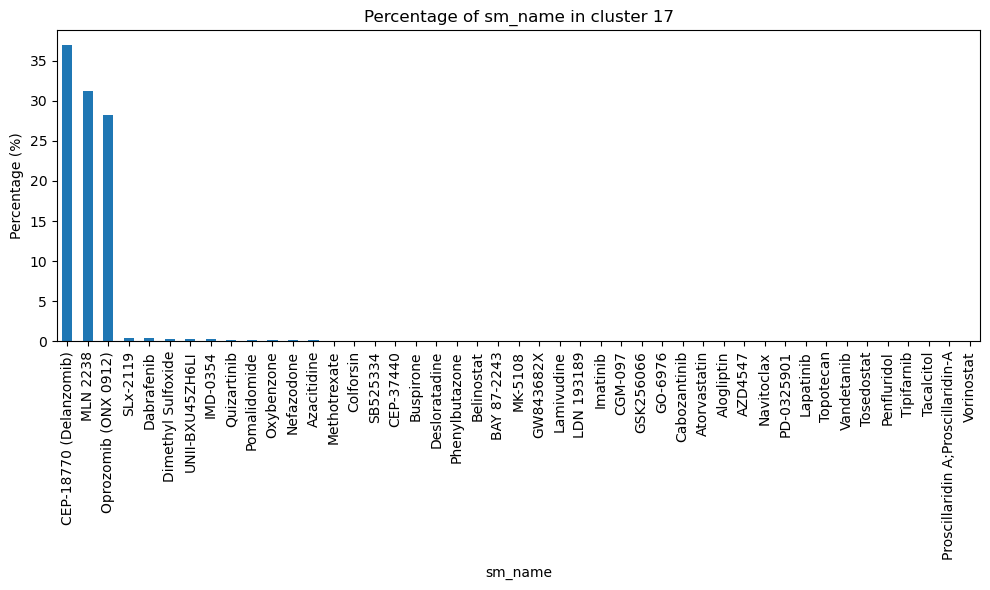

In [126]:
import matplotlib.pyplot as plt

def calculate_and_plot_sm_name_in_cluster(adata, cluster_column, cluster_label, plot_title=None):
    # Filter the AnnData object to include only the specified cluster
    adata_cluster = adata[adata.obs[cluster_column] == cluster_label]

    # Calculate the percentage of each sm_name within this cluster
    sm_name_counts = adata_cluster.obs['sm_name'].value_counts(normalize=True) * 100

    # Sort the percentages
    sm_name_counts_sorted = sm_name_counts.sort_values(ascending=False)

    # Print the sorted percentages
    print(f"Percentages of each sm_name in cluster {cluster_label}:")
    print(sm_name_counts_sorted.head(10))

    # Plotting the results
    plt.figure(figsize=(10, 6))
    sm_name_counts_sorted.plot(kind='bar')
    plt.title(plot_title if plot_title else f"Percentage of each sm_name in cluster {cluster_label}")
    plt.xlabel('sm_name')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=90)
    plt.tight_layout()  # Adjust layout to make room for label rotation
    plt.show()

    return sm_name_counts_sorted

cluster_percentages = calculate_and_plot_sm_name_in_cluster(sc_counts, 'leiden_res1', '17', "Percentage of sm_name in cluster 17")


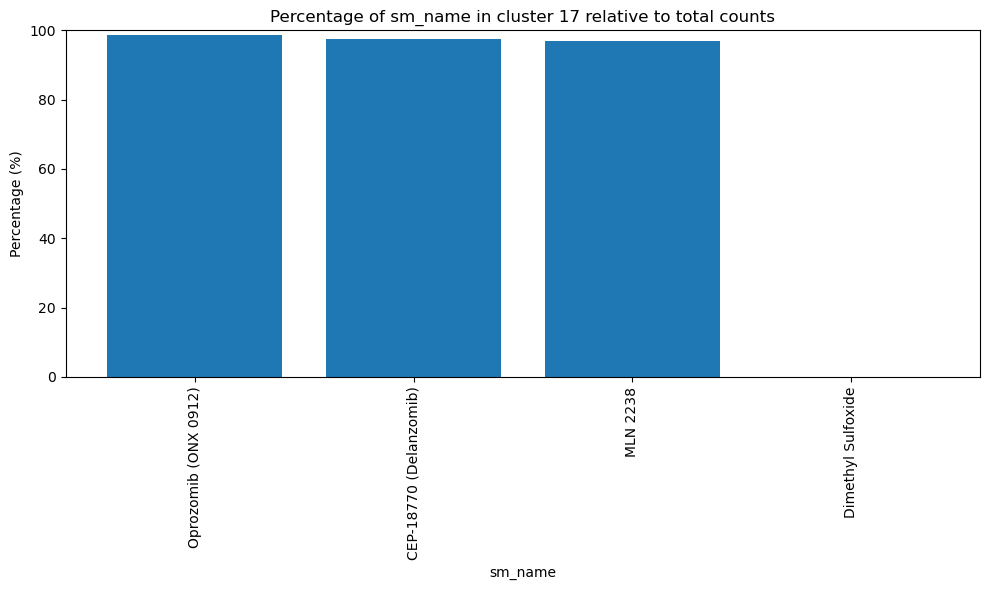

{'Oprozomib (ONX 0912)': 98.77049180327869, 'CEP-18770 (Delanzomib)': 97.52704791344668, 'MLN 2238': 96.91189827429609, 'Dimethyl Sulfoxide': 0.035134565385426184}


In [166]:
def calculate_percentage_in_cluster(adata, cluster_column, cluster_label, sm_names):
    # Filter the AnnData object to include only the specified cluster
    adata_cluster = adata[adata.obs[cluster_column] == cluster_label]
    
    # Calculate total counts of sm_names in the cluster
    sm_name_counts_in_cluster = adata_cluster.obs['sm_name'].value_counts()
    
    # Calculate total counts of sm_names in the entire dataset
    sm_name_counts_total = adata.obs['sm_name'].value_counts()
    
    # Calculate percentages of each sm_name within the cluster relative to the total dataset
    percentages = {}
    for sm_name in sm_names:
        if sm_name in sm_name_counts_in_cluster and sm_name in sm_name_counts_total:
            percentages[sm_name] = (sm_name_counts_in_cluster[sm_name] / sm_name_counts_total[sm_name]) * 100
        else:
            percentages[sm_name] = 0  # sm_name not found in cluster or overall counts
    
    # Sorting the percentages dictionary by values
    percentages_sorted = {k: v for k, v in sorted(percentages.items(), key=lambda item: item[1], reverse=True)}
    
    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.bar(percentages_sorted.keys(), percentages_sorted.values())
    plt.title(f"Percentage of sm_name in cluster {cluster_label} relative to total counts")
    plt.xlabel('sm_name')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=90)
    plt.ylim(0, 100)
    plt.tight_layout()  # Adjust layout to make room for label rotation
    plt.show()
    
    return percentages_sorted

# Example usage:
sm_names_list = ['CEP-18770 (Delanzomib)', 'MLN 2238', 'Oprozomib (ONX 0912)', "Dimethyl Sulfoxide"]  # replace these with actual sample names you're interested in
cluster_percentages = calculate_percentage_in_cluster(sc_counts, 'leiden_res1', '17', sm_names_list)
print(cluster_percentages)


In [149]:
# preliminary conclusion - cluster 17 cells' response indicates apoptosis, and stress response (HSPs, UBB, UBC, BAX, PMAIP1). Likely results from toxicity of the compounds. Downregulation of T cell markers CD3D, CD3E, CD3G distinguishes from T cells.  These cells are nearly exclusively present for 3 compounds. I recommend removing these cells from analysis since they likely indicate effects of toxicity.

In [150]:
sc_counts.obs['group'] = 'Other'

# Update group for cluster 17
sc_counts.obs.loc[sc_counts.obs['leiden_res1'] == '18', 'group'] = 'Cluster 18'

# Update group for DMSO T cells
condition = (sc_counts.obs['cell_type'].str.startswith('T ')) & (sc_counts.obs['sm_name'] == 'Dimethyl Sulfoxide')
sc_counts.obs.loc[condition, 'group'] = 'DMSO T Cells'

# Update group for DMSO NK
condition = (sc_counts.obs['cell_type'] == "NK cells") & (sc_counts.obs['sm_name'] == 'Dimethyl Sulfoxide')
sc_counts.obs.loc[condition, 'group'] = 'DMSO NK cells'

sc.tl.rank_genes_groups(sc_counts, groupby='group', reference='DMSO NK cells', method='t-test', use_raw=False)

In [151]:
# list the top DE genes
de_results = sc_counts.uns['rank_genes_groups']

gene_names = pd.DataFrame(de_results['names']['Cluster 18'], columns=['Gene'])
scores = pd.DataFrame(de_results['scores']['Cluster 18'], columns=['Score'])

# Combine into a single DataFrame
top_de_genes_cluster_18 = pd.concat([gene_names, scores], axis=1)

# Display the DataFrame
print(top_de_genes_cluster_18.head(50))

           Gene       Score
0        PABPC1  123.980637
1          TPT1  123.333138
2          FTH1  121.341141
3         RPL39   89.590271
4         RPS13   89.228058
5         RPS12   88.797035
6         RPL13   86.105492
7          CREM   85.795059
8         RPL32   83.097084
9         RPL11   80.620926
10        SARAF   80.163475
11        RPS3A   79.065315
12        RPS23   78.960289
13        RPL30   78.338867
14     HSP90AA1   75.796974
15        RPL34   74.585999
16       EEF1A1   73.427101
17     HSP90AB1   72.061264
18         RPL9   72.019417
19        RPL18   71.611176
20       RPS27A   71.472458
21        RPS14   71.445198
22         RPS8   71.353638
23        RPL19   70.259201
24        RPS4X   69.438210
25         RPS2   68.137520
26        RPLP2   64.324692
27       RPS15A   64.265160
28         NPM1   63.722279
29         RPS5   63.442627
30         RPL3   63.266598
31        RPS16   63.223831
32        RPS18   63.036903
33         RPS6   61.104935
34       RPL35A   60

In [152]:
print(top_de_genes_cluster_18.tail(50))

             Gene       Score
21215       CLIC3  -50.430958
21216       KLRB1  -51.210724
21217     ALOX5AP  -51.230652
21218  AC004687.1  -51.681507
21219        RAC2  -51.798576
21220       AHNAK  -53.381149
21221      IFITM2  -53.653431
21222       ISG15  -54.359848
21223      TMSB4X  -54.418140
21224    SH3BGRL3  -55.008495
21225       KLRG1  -55.287090
21226      RNF213  -55.587055
21227        ACTB  -55.789410
21228       ITGB2  -56.650280
21229        CTSC  -57.109077
21230      CORO1A  -58.133762
21231    C12ORF75  -59.676949
21232        LY6E  -61.117073
21233      TMSB10  -61.155731
21234       HLA-E  -61.707512
21235      TYROBP  -61.964363
21236       PSMB9  -62.641335
21237        IL32  -64.160477
21238        GZMM  -64.916183
21239       HLA-F  -66.921295
21240       CLIC1  -67.799881
21241        GZMH  -68.669746
21242       EFHD2  -69.668831
21243        TRDC  -70.399986
21244      MYL12A  -73.593681
21245        CCL4  -73.746216
21246        PRF1  -73.789474
21247    A

In [153]:
sc.tl.rank_genes_groups(sc_counts, groupby='group', reference='DMSO T Cells', method='t-test', use_raw=False)
# list the top DE genes
de_results = sc_counts.uns['rank_genes_groups']

gene_names = pd.DataFrame(de_results['names']['Cluster 18'], columns=['Gene'])
scores = pd.DataFrame(de_results['scores']['Cluster 18'], columns=['Score'])

# Combine into a single DataFrame
top_de_genes_cluster_18 = pd.concat([gene_names, scores], axis=1)

# Display the DataFrame
print(top_de_genes_cluster_18.head(50))

          Gene       Score
0         FTH1  116.918427
1     HSP90AA1   99.195107
2       PABPC1   89.372650
3         CREM   83.015724
4     HSP90AB1   71.410934
5         SRGN   48.537975
6       PIK3R1   46.766869
7        HSPD1   46.048119
8        CXCR4   45.451557
9         TPT1   43.618385
10       SARAF   43.088371
11       HSPH1   40.731796
12        ST13   40.227024
13       HSPE1   38.890324
14        SOD1   37.497799
15       SESN3   37.118015
16      CACYBP   36.951153
17        CD55   36.127052
18       SYTL3   36.037445
19       JOSD1   34.612720
20         FYN   33.429028
21        CCT3   32.443794
22     CHORDC1   32.368473
23        NPM1   32.351959
24        RGS2   31.899513
25       HSPA8   31.866867
26       EEF1D   31.294655
27      CNOT6L   30.736647
28   GABARAPL1   29.367100
29       SDCBP   29.264111
30      DNAJB6   27.392893
31  AC136475.3   27.319578
32      PTGES3   27.150406
33         CD7   26.563133
34      SMCHD1   26.540558
35     TNFAIP3   26.492241
3

In [154]:
print(top_de_genes_cluster_18.tail(50))

           Gene      Score
21215      LDHA -38.576973
21216      RTP4 -38.658382
21217     GSTK1 -39.711678
21218      OAS1 -40.221039
21219      HCST -40.584827
21220      EMP3 -40.888351
21221     AHNAK -41.817722
21222   TNFSF10 -41.873283
21223   CCDC85B -42.675728
21224     PSME2 -42.813583
21225    EPSTI1 -43.205490
21226      IRF1 -43.382500
21227      ACTB -43.644051
21228      GBP1 -43.817753
21229    GIMAP1 -44.985241
21230      TRAC -45.292995
21231      CD52 -45.357521
21232     PARP9 -45.939323
21233    RNF213 -46.859249
21234    GIMAP7 -47.033623
21235  TRAF3IP3 -47.616020
21236     RSAD2 -47.720909
21237      CD48 -47.942425
21238     HLA-E -48.471149
21239      PFN1 -49.433002
21240    SAMD9L -50.129868
21241       LTB -50.393963
21242     HLA-C -51.208969
21243     PSMB9 -51.495670
21244     HLA-A -51.864277
21245     HLA-F -53.561787
21246      RAC2 -53.713306
21247      XAF1 -54.395401
21248    CORO1A -54.472092
21249     IFIT1 -54.478500
21250     HLA-B -54.824379
2

Percentages of each sm_name in cluster 18:
sm_name
Ganetespib (STA-9090)    53.399015
AT13387                  38.275862
BAY 61-3606               0.837438
Dabrafenib                0.788177
Dimethyl Sulfoxide        0.738916
IMD-0354                  0.689655
SLx-2119                  0.394089
AT 7867                   0.246305
GSK256066                 0.197044
Colforsin                 0.197044
Name: proportion, dtype: float64


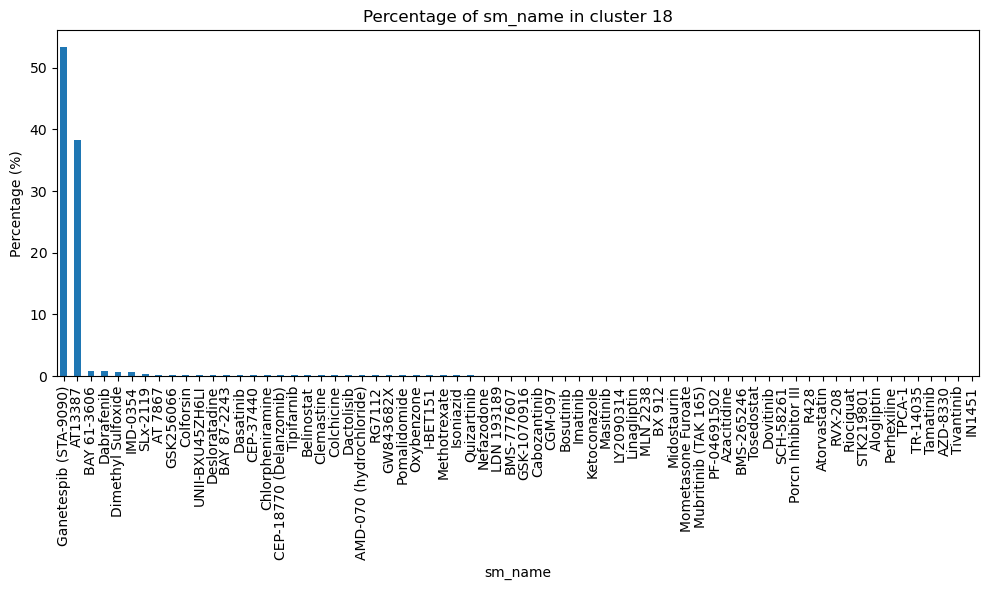

In [134]:
cluster_percentages = calculate_and_plot_sm_name_in_cluster(sc_counts, 'leiden_res1', '18', "Percentage of sm_name in cluster 18")

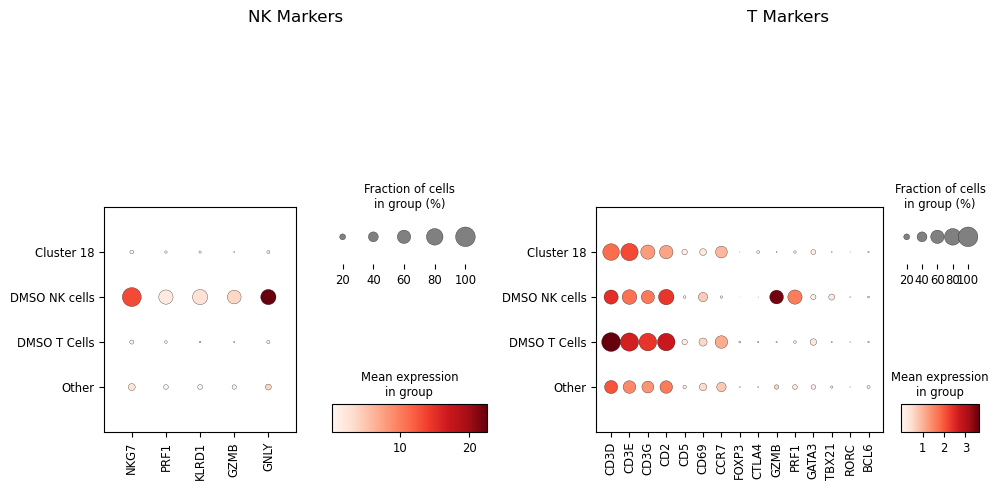

In [164]:
def plot_marker_expression(adata, markers, groupby):
    """
    This function plots the expression of given markers across specified groups (e.g., cell types).
    
    Parameters:
        adata (AnnData): The annotated data matrix of shape (n_obs, n_vars). Rows correspond to cells and columns to genes.
        markers (dict): A dictionary where keys are the cell types and values are lists of markers associated with each cell type.
        groupby (str): The key in adata.obs that corresponds to the grouping variable (e.g., predicted cell type).
    """
    # Initialize the figure
    num_types = len(markers)
    fig, axs = plt.subplots(1, num_types, figsize=(5*num_types, 5), squeeze=False)

    for i, (cell_type, marker_list) in enumerate(markers.items()):
        # Filter data for the markers of the current cell type
        sc.pl.dotplot(adata, var_names=marker_list, groupby=groupby, ax=axs[0, i], show=False)
        axs[0, i].set_title(f'{cell_type} Markers')

    plt.tight_layout()
    plt.show()

markers_t_nk = {
    'NK': ['NKG7', 'PRF1', 'KLRD1', 'GZMB', 'GNLY'],
    'T': ['CD3D', 'CD3E', 'CD3G', 'CD2', 'CD5', 'CD69',
                      'CCR7', 'FOXP3', 'CTLA4', 'GZMB', 'PRF1',
                      'GATA3', 'TBX21', 'RORC', 'BCL6']
}

groupby = 'group'  # This should be the column in adata.obs with your cell type predictions

plot_marker_expression(sc_counts, markers_t_nk, groupby)

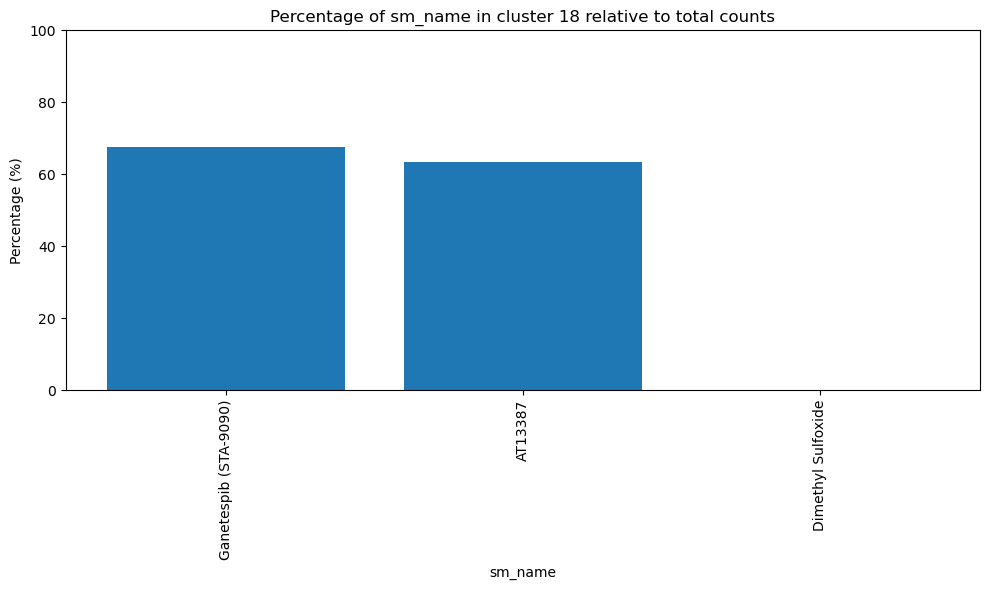

{'Ganetespib (STA-9090)': 67.45488487865589, 'AT13387': 63.376835236541595, 'Dimethyl Sulfoxide': 0.052701848078139275}


In [167]:
sm_names_list = ['Ganetespib (STA-9090)', 'AT13387', "Dimethyl Sulfoxide"]  # replace these with actual sample names you're interested in
cluster_percentages = calculate_percentage_in_cluster(sc_counts, 'leiden_res1', '18', sm_names_list)
print(cluster_percentages)

In [169]:
# check what fraction of the dataset are T cells
sc_counts.obs['is_t'] = sc_counts.obs['cell_type'].str.startswith('T ')
sc_counts.obs['is_t'].mean() * 100

49.29801017280514

In [170]:
# preliminary conclusion - cells from cluster 18 seem to be closer to T cells rather than NK cells, indicating misclassification. I recommend reclassifying these cells as T cells. Cells are likely stressed or activated. The cells are a significant fraction of all of the cells for a given compound, but not nearly all of the cells. I recommend keeping these cells and making sure that the annotation of other cells for these compounds is correct, since we already observed on plots that other cells may be misclassified.